In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
from chnet.torchsummary import summary
from torchvision import transforms, utils
from toolz.curried import pipe, curry, compose
from torch.utils.data import Dataset, DataLoader

In [3]:
import utilities as utils
import chnet.cahn_hill as ch
import chnet.ch_tools as tools

In [4]:
from chnet.unet import UNet
from chnet.ch_net import CHnet
from chnet.ch_loader import CahnHillDataset

In [5]:
warnings.filterwarnings('ignore')

In [6]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=5)

In [7]:
def init_unif(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    return np.random.uniform(-0.95, 0.95, size=(nsamples, dim_x, dim_y))


def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.1, 0.1, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.1, 0.5, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.95, 0.95, out=x_data)
    
    return x_data

## Loss Functions

In [8]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

## Transformers

In [9]:
@curry
def add_neighbors(x):
    dimx = x.shape[0]
    y = np.pad(x, pad_width=[[2,2],[2,2]], mode="wrap")
    out = [x[None]]
    for ix in [0, 1, 2, 3, 4]:
        for iy in [0, 1, 2, 3, 4]:
            out.append((y[ix:ix+dimx, iy:iy+dimx] * x)[None])
    return np.concatenate(out, axis=0)

## Data Generators

In [10]:
@curry
def data_generator(nsamples=128, 
                   dim_x=64, 
                   init_steps=100, 
                   delta_sim_steps = 500,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   device = torch.device("cuda:0")):
    
    init_data1 = init_unif(nsamples//2, dim_x, dim_x, seed=seed)
    init_data2 = init_norm(nsamples//2, dim_x, dim_x, seed=seed)
    init_data = np.concatenate([init_data1, init_data2], axis=0)
    
    x_data = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, device=device)
    y_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps+delta_sim_steps, device=device)
    return x_data, y_data

In [11]:
x_data, y_data = data_generator(nsamples=16, dim_x=64, 
                                init_steps=10, 
                                delta_sim_steps = 50,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed = None,
                                device = torch.device("cuda:0"))

# Set Device

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN Model

In [13]:
from chnet.unet import UNet
model = UNet(in_channels=1, 
             out_channels=1, 
             init_features=32).to(device)
summary(model, input_size=(1, 64, 64))

# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
#                        in_channels=1, 
#                        out_channels=1, 
#                        init_features=32, 
#                        pretrained=False).double().to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             288
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,216
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
         MaxPool2d-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          18,432
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

(tensor(7762465), tensor(7762465))

In [15]:
transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]

dataset = CahnHillDataset(x_data, y_data, transform_x=transformer_x, transform_y=transformer_y)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

print(x.shape, y.shape)

torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])


In [16]:
model = UNet(in_channels=1, 
             out_channels=1, 
             init_features=32).double().to(device)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)
y_pred = model(x)

assert y.shape == y_pred.shape
print(mse_loss(y, y_pred).data)

tensor(0.1177, device='cuda:0', dtype=torch.float64)


# Model Training

### Training and Validation data generation

In [17]:
## Process Parameters
dim_x=64
init_steps=10
delta_sim_steps = 2000
dx = 0.25 
dt = 0.01
gamma=1.0

seed_trn = 110364
seed_val = 986423
seed_prd = 284296

n_samples_trn = 1024*20
n_samples_val = 128
n_samples_prd = 32

init_features=32

In [18]:
args = {}
args["dim_x"] = dim_x
args["init_steps"] = init_steps
args["delta_sim_steps"] = delta_sim_steps
args["dx"] = dx
args["dt"] = dt
args["gamma"] = gamma
args["seed_trn"] = seed_trn
args["seed_val"] = seed_val
args["seed_val"] = seed_prd

args["n_samples_trn"] = n_samples_trn
args["n_samples_val"] = n_samples_val
args["n_samples_prd"] = n_samples_prd

args["init_features"] = init_features

In [19]:
%%time
x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_trn,
                                device = device)



x_val, y_val = data_generator(nsamples=n_samples_val, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_val,
                                device = device)

x_prd, y_prd = data_generator(nsamples=n_samples_prd, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_prd,
                                device = device)

CPU times: user 39.1 s, sys: 36.1 s, total: 1min 15s
Wall time: 1min 13s


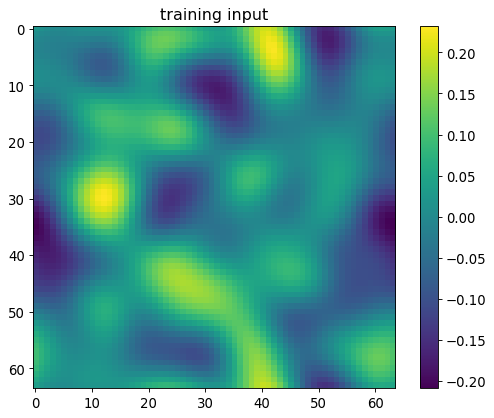

In [20]:
draw_im(x_trn[0], "training input")

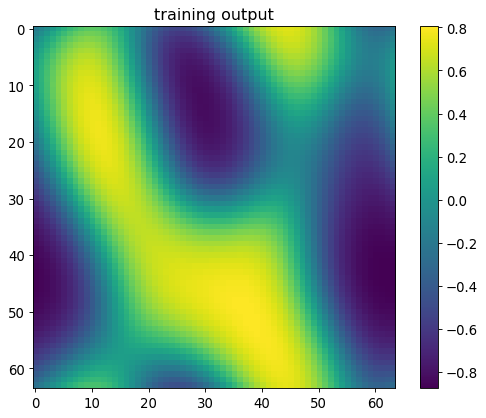

In [21]:
draw_im(y_trn[0], "training output")

In [22]:
transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]

trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
prd_dataset = CahnHillDataset(x_prd, y_prd, transform_x=transformer_x, transform_y=transformer_y)

batch_size = 4

trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
prd_loader = DataLoader(prd_dataset, batch_size=8, shuffle=True, num_workers=1)


total_step = len(trn_loader)
print("No. of training steps: %d" % total_step)
total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)
total_val_step = len(prd_loader)
print("No. of prediction steps: %d" % total_val_step)

No. of training steps: 5120
No. of validation steps: 32
No. of prediction steps: 4


In [23]:
dt_string = datetime.now().strftime("%d-%m-%Y-%H-%M")

In [24]:
run = 10
run_id = dt_string + "_run_" + "plain"
print(run_id)

folder = "out/unet/ch_unet_id_{}/".format(run_id)
print(folder)

if not os.path.exists(folder):
    os.makedirs(folder)
    
with open(folder+'params.json', 'w') as fp:
    json.dump(args, fp)
    
tag = folder+"unet_"
print(tag)

12-04-2020-15-39_run_plain
out/unet/ch_unet_id_12-04-2020-15-39_run_plain/
out/unet/ch_unet_id_12-04-2020-15-39_run_plain/unet_


In [25]:
from chnet.unet import UNet
model = UNet(in_channels=1, 
             out_channels=1, 
             init_features=init_features).double().to(device)

In [26]:
num_epochs = 20
criterion = mse_loss(scale=10000)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
trn_losses = []
val_losses = []

In [27]:
# Loss and optimizer
for epoch in range(num_epochs):    
    torch.save(model.state_dict(), tag+"epoch_{}.pt".format(epoch))              
    for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):
        
        
        model.train()
        
        x = item_trn['x'].to(device)
        y_tru = item_trn['y'].to(device)

        # Forward pass
        y_prd = model(x)
        loss = criterion(y_tru, y_prd)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trn_losses.append(np.sqrt(loss.item()))
        
        if (i) % 64 == 0:
            for item_val in val_loader:
                model.eval()
                x1 = item_trn['x'].to(device)
                y1 = item_trn['y'].to(device)
                # Forward pass
                y2 = model(x1)
                val_losses.append(np.sqrt(criterion(y2, y1).item()))
                    
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}, Validation Loss: {:.11f}'.format(epoch+1, 
                                                                                                          num_epochs, 
                                                                                                          i+1, 
                                                                                                          total_step, 
                                                                                                          np.mean(trn_losses[-16:]), 
                                                                                                          np.mean(val_losses[-total_val_step:])))
            
# torch.save(model.state_dict(), tag+"epoch_{}.pt".format(num_epochs)) 

Epoch [1/20], Step [1/5120], Training Loss: 56.72432416338, Validation Loss: 47.78181144639
Epoch [1/20], Step [65/5120], Training Loss: 48.30753058387, Validation Loss: 53.53340227931
Epoch [1/20], Step [129/5120], Training Loss: 46.18570529809, Validation Loss: 41.41810996538
Epoch [1/20], Step [193/5120], Training Loss: 45.13543965065, Validation Loss: 46.37648131929
Epoch [1/20], Step [257/5120], Training Loss: 40.73868684656, Validation Loss: 44.75006956373
Epoch [1/20], Step [321/5120], Training Loss: 34.53702102326, Validation Loss: 35.17720478516
Epoch [1/20], Step [385/5120], Training Loss: 30.67600389239, Validation Loss: 28.80628351683
Epoch [1/20], Step [449/5120], Training Loss: 28.40143275660, Validation Loss: 28.76276345553
Epoch [1/20], Step [513/5120], Training Loss: 27.03944895703, Validation Loss: 29.16680249463
Epoch [1/20], Step [577/5120], Training Loss: 25.71581671198, Validation Loss: 24.66712637135
Epoch [1/20], Step [641/5120], Training Loss: 25.36088414590, V

Epoch [2/20], Step [1/5120], Training Loss: 10.56256332552, Validation Loss: 9.99131228604
Epoch [2/20], Step [65/5120], Training Loss: 10.51175989677, Validation Loss: 9.60384016757
Epoch [2/20], Step [129/5120], Training Loss: 10.28242853666, Validation Loss: 9.70033724981
Epoch [2/20], Step [193/5120], Training Loss: 10.14996350335, Validation Loss: 8.65177861903
Epoch [2/20], Step [257/5120], Training Loss: 10.00376798608, Validation Loss: 9.12548458925
Epoch [2/20], Step [321/5120], Training Loss: 10.57429121630, Validation Loss: 11.00346446501
Epoch [2/20], Step [385/5120], Training Loss: 10.54292318333, Validation Loss: 9.54807261521
Epoch [2/20], Step [449/5120], Training Loss: 10.57199031744, Validation Loss: 10.58125303744
Epoch [2/20], Step [513/5120], Training Loss: 10.52705137574, Validation Loss: 13.24863246136
Epoch [2/20], Step [577/5120], Training Loss: 9.89012062623, Validation Loss: 10.13938353110
Epoch [2/20], Step [641/5120], Training Loss: 10.21211357502, Validati

Epoch [3/20], Step [1/5120], Training Loss: 8.36620600797, Validation Loss: 6.79426999213
Epoch [3/20], Step [65/5120], Training Loss: 8.01854972117, Validation Loss: 8.58549030414
Epoch [3/20], Step [129/5120], Training Loss: 7.98808230104, Validation Loss: 11.57130650464
Epoch [3/20], Step [193/5120], Training Loss: 8.08312980635, Validation Loss: 6.93199743822
Epoch [3/20], Step [257/5120], Training Loss: 8.16740425523, Validation Loss: 8.72874673408
Epoch [3/20], Step [321/5120], Training Loss: 7.91356679442, Validation Loss: 6.36370251259
Epoch [3/20], Step [385/5120], Training Loss: 7.91809183742, Validation Loss: 7.43574891483
Epoch [3/20], Step [449/5120], Training Loss: 8.12679753673, Validation Loss: 7.25292836665
Epoch [3/20], Step [513/5120], Training Loss: 7.77427552064, Validation Loss: 7.93364028604
Epoch [3/20], Step [577/5120], Training Loss: 8.29350194683, Validation Loss: 6.83137990064
Epoch [3/20], Step [641/5120], Training Loss: 7.78181911741, Validation Loss: 10.8

Epoch [4/20], Step [1/5120], Training Loss: 6.93551740132, Validation Loss: 6.47027555622
Epoch [4/20], Step [65/5120], Training Loss: 6.83738046251, Validation Loss: 6.03993704819
Epoch [4/20], Step [129/5120], Training Loss: 7.59011676590, Validation Loss: 10.37505111300
Epoch [4/20], Step [193/5120], Training Loss: 7.13543398970, Validation Loss: 6.42356678286
Epoch [4/20], Step [257/5120], Training Loss: 6.62491880718, Validation Loss: 5.75186888734
Epoch [4/20], Step [321/5120], Training Loss: 7.08210153821, Validation Loss: 5.94371483361
Epoch [4/20], Step [385/5120], Training Loss: 7.17292406335, Validation Loss: 6.53722051018
Epoch [4/20], Step [449/5120], Training Loss: 6.84308329461, Validation Loss: 8.34843289061
Epoch [4/20], Step [513/5120], Training Loss: 6.82102921697, Validation Loss: 5.72051917490
Epoch [4/20], Step [577/5120], Training Loss: 6.63241018858, Validation Loss: 5.58156312258
Epoch [4/20], Step [641/5120], Training Loss: 7.15280811173, Validation Loss: 6.21

Epoch [5/20], Step [1/5120], Training Loss: 6.75089754233, Validation Loss: 4.71069079704
Epoch [5/20], Step [65/5120], Training Loss: 6.02514385104, Validation Loss: 5.72619018951
Epoch [5/20], Step [129/5120], Training Loss: 6.36349349199, Validation Loss: 6.17806329439
Epoch [5/20], Step [193/5120], Training Loss: 6.66756626752, Validation Loss: 5.76797775381
Epoch [5/20], Step [257/5120], Training Loss: 6.31756393734, Validation Loss: 7.56543147032
Epoch [5/20], Step [321/5120], Training Loss: 6.24140413592, Validation Loss: 7.83157141034
Epoch [5/20], Step [385/5120], Training Loss: 6.54928674701, Validation Loss: 6.70183733174
Epoch [5/20], Step [449/5120], Training Loss: 6.24278413637, Validation Loss: 6.18485907798
Epoch [5/20], Step [513/5120], Training Loss: 6.19599146354, Validation Loss: 5.74599921372
Epoch [5/20], Step [577/5120], Training Loss: 5.86915033629, Validation Loss: 5.67226408868
Epoch [5/20], Step [641/5120], Training Loss: 6.44944584080, Validation Loss: 8.908

Epoch [6/20], Step [1/5120], Training Loss: 6.17906798907, Validation Loss: 6.18413486593
Epoch [6/20], Step [65/5120], Training Loss: 5.96710339087, Validation Loss: 4.81042375988
Epoch [6/20], Step [129/5120], Training Loss: 5.66807185204, Validation Loss: 4.62303178293
Epoch [6/20], Step [193/5120], Training Loss: 5.69472238958, Validation Loss: 5.74370576560
Epoch [6/20], Step [257/5120], Training Loss: 5.46147146619, Validation Loss: 5.18541085693
Epoch [6/20], Step [321/5120], Training Loss: 5.84127828046, Validation Loss: 5.05940554850
Epoch [6/20], Step [385/5120], Training Loss: 6.29477401189, Validation Loss: 4.68882604616
Epoch [6/20], Step [449/5120], Training Loss: 5.78675635027, Validation Loss: 7.15562533631
Epoch [6/20], Step [513/5120], Training Loss: 5.79177502218, Validation Loss: 5.26014137883
Epoch [6/20], Step [577/5120], Training Loss: 5.91323550518, Validation Loss: 5.51771257577
Epoch [6/20], Step [641/5120], Training Loss: 5.92173189917, Validation Loss: 5.024

Epoch [7/20], Step [1/5120], Training Loss: 5.86849036200, Validation Loss: 5.09903445835
Epoch [7/20], Step [65/5120], Training Loss: 5.36397295847, Validation Loss: 4.19392078695
Epoch [7/20], Step [129/5120], Training Loss: 5.65498625486, Validation Loss: 4.92566654194
Epoch [7/20], Step [193/5120], Training Loss: 5.43278280519, Validation Loss: 9.54977829765
Epoch [7/20], Step [257/5120], Training Loss: 5.65653538468, Validation Loss: 6.28225710014
Epoch [7/20], Step [321/5120], Training Loss: 5.95103666558, Validation Loss: 5.56590861801
Epoch [7/20], Step [385/5120], Training Loss: 5.76977136532, Validation Loss: 8.40099284812
Epoch [7/20], Step [449/5120], Training Loss: 5.09994077912, Validation Loss: 7.72582903459
Epoch [7/20], Step [513/5120], Training Loss: 5.41453033824, Validation Loss: 9.05723160703
Epoch [7/20], Step [577/5120], Training Loss: 5.38341172564, Validation Loss: 4.77644139747
Epoch [7/20], Step [641/5120], Training Loss: 5.68713660843, Validation Loss: 4.384

Epoch [8/20], Step [1/5120], Training Loss: 5.81121265800, Validation Loss: 4.38670477504
Epoch [8/20], Step [65/5120], Training Loss: 5.98018413775, Validation Loss: 4.23683631520
Epoch [8/20], Step [129/5120], Training Loss: 4.90299930407, Validation Loss: 4.28980080514
Epoch [8/20], Step [193/5120], Training Loss: 5.23168654620, Validation Loss: 4.71908209317
Epoch [8/20], Step [257/5120], Training Loss: 4.71672619108, Validation Loss: 4.34969337621
Epoch [8/20], Step [321/5120], Training Loss: 5.94569851088, Validation Loss: 6.61516153151
Epoch [8/20], Step [385/5120], Training Loss: 5.46007630565, Validation Loss: 4.97415399462
Epoch [8/20], Step [449/5120], Training Loss: 5.02882252266, Validation Loss: 6.54716513456
Epoch [8/20], Step [513/5120], Training Loss: 5.07065610525, Validation Loss: 4.95143020220
Epoch [8/20], Step [577/5120], Training Loss: 5.10148161423, Validation Loss: 4.51052624200
Epoch [8/20], Step [641/5120], Training Loss: 5.13259162772, Validation Loss: 4.108

Epoch [9/20], Step [1/5120], Training Loss: 4.95998498703, Validation Loss: 6.58902777341
Epoch [9/20], Step [65/5120], Training Loss: 4.58823147184, Validation Loss: 4.70119146397
Epoch [9/20], Step [129/5120], Training Loss: 4.82259311515, Validation Loss: 4.56017314086
Epoch [9/20], Step [193/5120], Training Loss: 4.63168155533, Validation Loss: 4.30110982297
Epoch [9/20], Step [257/5120], Training Loss: 5.09025816762, Validation Loss: 4.55921592327
Epoch [9/20], Step [321/5120], Training Loss: 5.15382512438, Validation Loss: 5.20851527451
Epoch [9/20], Step [385/5120], Training Loss: 4.75589354307, Validation Loss: 5.23755374820
Epoch [9/20], Step [449/5120], Training Loss: 4.76327485793, Validation Loss: 4.39434484633
Epoch [9/20], Step [513/5120], Training Loss: 4.83341845106, Validation Loss: 6.80784434445
Epoch [9/20], Step [577/5120], Training Loss: 4.68964127282, Validation Loss: 4.36887531184
Epoch [9/20], Step [641/5120], Training Loss: 4.56781227918, Validation Loss: 5.270

Epoch [10/20], Step [1/5120], Training Loss: 5.01128451729, Validation Loss: 4.45973960526
Epoch [10/20], Step [65/5120], Training Loss: 5.08486404941, Validation Loss: 7.83421252143
Epoch [10/20], Step [129/5120], Training Loss: 4.78529121844, Validation Loss: 4.09713787391
Epoch [10/20], Step [193/5120], Training Loss: 4.88634355571, Validation Loss: 3.85344223548
Epoch [10/20], Step [257/5120], Training Loss: 4.32181064279, Validation Loss: 5.68312154936
Epoch [10/20], Step [321/5120], Training Loss: 4.74755250217, Validation Loss: 6.81384651134
Epoch [10/20], Step [385/5120], Training Loss: 4.81819644144, Validation Loss: 6.75470049485
Epoch [10/20], Step [449/5120], Training Loss: 4.54687561134, Validation Loss: 6.97737520022
Epoch [10/20], Step [513/5120], Training Loss: 4.23840879618, Validation Loss: 4.17522712838
Epoch [10/20], Step [577/5120], Training Loss: 4.55918038137, Validation Loss: 4.61541982180
Epoch [10/20], Step [641/5120], Training Loss: 4.57922869646, Validation 

Epoch [11/20], Step [1/5120], Training Loss: 4.70379237486, Validation Loss: 4.82418980417
Epoch [11/20], Step [65/5120], Training Loss: 4.37350746812, Validation Loss: 5.25554915466
Epoch [11/20], Step [129/5120], Training Loss: 4.37399607951, Validation Loss: 3.89997822625
Epoch [11/20], Step [193/5120], Training Loss: 4.21714450868, Validation Loss: 3.71121252546
Epoch [11/20], Step [257/5120], Training Loss: 4.50755640217, Validation Loss: 5.58504044257
Epoch [11/20], Step [321/5120], Training Loss: 4.44291269520, Validation Loss: 4.24263188957
Epoch [11/20], Step [385/5120], Training Loss: 4.90710995307, Validation Loss: 8.16337384104
Epoch [11/20], Step [449/5120], Training Loss: 4.27988495159, Validation Loss: 4.83405681358
Epoch [11/20], Step [513/5120], Training Loss: 4.34022517122, Validation Loss: 4.04559383906
Epoch [11/20], Step [577/5120], Training Loss: 4.43716591414, Validation Loss: 4.25326532988
Epoch [11/20], Step [641/5120], Training Loss: 4.63742430639, Validation 

Epoch [12/20], Step [1/5120], Training Loss: 4.39917638829, Validation Loss: 5.36210215269
Epoch [12/20], Step [65/5120], Training Loss: 4.18110517468, Validation Loss: 5.03922624611
Epoch [12/20], Step [129/5120], Training Loss: 4.41354348478, Validation Loss: 3.93262608199
Epoch [12/20], Step [193/5120], Training Loss: 4.19087533556, Validation Loss: 3.49470905937
Epoch [12/20], Step [257/5120], Training Loss: 4.09051073893, Validation Loss: 4.68288764176
Epoch [12/20], Step [321/5120], Training Loss: 4.17493620191, Validation Loss: 3.74376151584
Epoch [12/20], Step [385/5120], Training Loss: 4.60251140592, Validation Loss: 3.90099236340
Epoch [12/20], Step [449/5120], Training Loss: 4.36712655509, Validation Loss: 7.55295534930
Epoch [12/20], Step [513/5120], Training Loss: 4.14676080329, Validation Loss: 5.78244702414
Epoch [12/20], Step [577/5120], Training Loss: 4.21238574379, Validation Loss: 3.81284411239
Epoch [12/20], Step [641/5120], Training Loss: 4.11514495954, Validation 

Epoch [13/20], Step [1/5120], Training Loss: 4.04689435616, Validation Loss: 3.30504295096
Epoch [13/20], Step [65/5120], Training Loss: 4.08759426205, Validation Loss: 4.13306623553
Epoch [13/20], Step [129/5120], Training Loss: 3.87165677790, Validation Loss: 3.55347350212
Epoch [13/20], Step [193/5120], Training Loss: 4.06865474238, Validation Loss: 3.52614942169
Epoch [13/20], Step [257/5120], Training Loss: 4.22428713638, Validation Loss: 3.71910793989
Epoch [13/20], Step [321/5120], Training Loss: 4.26741813772, Validation Loss: 4.01409759554
Epoch [13/20], Step [385/5120], Training Loss: 4.35631635687, Validation Loss: 3.92090136833
Epoch [13/20], Step [449/5120], Training Loss: 4.20272071738, Validation Loss: 4.53228451662
Epoch [13/20], Step [513/5120], Training Loss: 3.91458068134, Validation Loss: 3.89386267777
Epoch [13/20], Step [577/5120], Training Loss: 3.99857347773, Validation Loss: 4.90925603187
Epoch [13/20], Step [641/5120], Training Loss: 4.16192437824, Validation 

Epoch [14/20], Step [1/5120], Training Loss: 4.10413260971, Validation Loss: 3.34799828150
Epoch [14/20], Step [65/5120], Training Loss: 3.77305301998, Validation Loss: 3.95516812194
Epoch [14/20], Step [129/5120], Training Loss: 4.02379695833, Validation Loss: 7.00645988344
Epoch [14/20], Step [193/5120], Training Loss: 4.13208472374, Validation Loss: 6.13777158426
Epoch [14/20], Step [257/5120], Training Loss: 3.81989317709, Validation Loss: 3.88311632426
Epoch [14/20], Step [321/5120], Training Loss: 3.99547255396, Validation Loss: 3.74835777826
Epoch [14/20], Step [385/5120], Training Loss: 4.05882604555, Validation Loss: 3.25175972473
Epoch [14/20], Step [449/5120], Training Loss: 4.30716695986, Validation Loss: 5.72109326569
Epoch [14/20], Step [513/5120], Training Loss: 3.97119516222, Validation Loss: 3.55231300398
Epoch [14/20], Step [577/5120], Training Loss: 3.85503080360, Validation Loss: 3.79246638878
Epoch [14/20], Step [641/5120], Training Loss: 4.19128378576, Validation 

Epoch [15/20], Step [1/5120], Training Loss: 3.81846728190, Validation Loss: 3.62386341947
Epoch [15/20], Step [65/5120], Training Loss: 4.06889595363, Validation Loss: 3.53744444304
Epoch [15/20], Step [129/5120], Training Loss: 3.83240992307, Validation Loss: 3.35013726107
Epoch [15/20], Step [193/5120], Training Loss: 3.57724896967, Validation Loss: 3.40622560568
Epoch [15/20], Step [257/5120], Training Loss: 3.93430897836, Validation Loss: 3.47249081506
Epoch [15/20], Step [321/5120], Training Loss: 3.83712957259, Validation Loss: 3.80467341037
Epoch [15/20], Step [385/5120], Training Loss: 3.65296408307, Validation Loss: 3.42915864827
Epoch [15/20], Step [449/5120], Training Loss: 3.96253215539, Validation Loss: 3.74415603487
Epoch [15/20], Step [513/5120], Training Loss: 3.67229699601, Validation Loss: 3.41371106752
Epoch [15/20], Step [577/5120], Training Loss: 3.83037454875, Validation Loss: 3.76554453405
Epoch [15/20], Step [641/5120], Training Loss: 3.45727051047, Validation 

Epoch [16/20], Step [1/5120], Training Loss: 3.69229643454, Validation Loss: 4.45298069107
Epoch [16/20], Step [65/5120], Training Loss: 3.58677994058, Validation Loss: 3.07540119265
Epoch [16/20], Step [129/5120], Training Loss: 3.66862172917, Validation Loss: 7.03114080729
Epoch [16/20], Step [193/5120], Training Loss: 3.62933638212, Validation Loss: 3.27909471723
Epoch [16/20], Step [257/5120], Training Loss: 3.69490352522, Validation Loss: 5.31611239018
Epoch [16/20], Step [321/5120], Training Loss: 3.90966310233, Validation Loss: 3.57340893587
Epoch [16/20], Step [385/5120], Training Loss: 3.51702409722, Validation Loss: 4.29632444491
Epoch [16/20], Step [449/5120], Training Loss: 3.62340670235, Validation Loss: 3.88023557636
Epoch [16/20], Step [513/5120], Training Loss: 3.51609449213, Validation Loss: 3.50692765384
Epoch [16/20], Step [577/5120], Training Loss: 3.87238581511, Validation Loss: 5.55091776850
Epoch [16/20], Step [641/5120], Training Loss: 3.90162687545, Validation 

Epoch [17/20], Step [1/5120], Training Loss: 3.66001904971, Validation Loss: 4.35628151008
Epoch [17/20], Step [65/5120], Training Loss: 3.63642332902, Validation Loss: 3.41663356693
Epoch [17/20], Step [129/5120], Training Loss: 3.59245233314, Validation Loss: 4.05542148497
Epoch [17/20], Step [193/5120], Training Loss: 3.80088927265, Validation Loss: 3.55024812667
Epoch [17/20], Step [257/5120], Training Loss: 3.44723016903, Validation Loss: 3.38347957264
Epoch [17/20], Step [321/5120], Training Loss: 3.62585316731, Validation Loss: 3.67423388772
Epoch [17/20], Step [385/5120], Training Loss: 3.84952743414, Validation Loss: 5.29228238474
Epoch [17/20], Step [449/5120], Training Loss: 3.36671888272, Validation Loss: 5.23416264356
Epoch [17/20], Step [513/5120], Training Loss: 3.46346135151, Validation Loss: 3.52000812681
Epoch [17/20], Step [577/5120], Training Loss: 3.48135744433, Validation Loss: 3.35851982412
Epoch [17/20], Step [641/5120], Training Loss: 3.71644044146, Validation 

Epoch [18/20], Step [1/5120], Training Loss: 4.03812829334, Validation Loss: 3.32446254536
Epoch [18/20], Step [65/5120], Training Loss: 3.56059974063, Validation Loss: 3.42024400307
Epoch [18/20], Step [129/5120], Training Loss: 3.88284850483, Validation Loss: 4.10315561712
Epoch [18/20], Step [193/5120], Training Loss: 3.55057257670, Validation Loss: 3.85606432258
Epoch [18/20], Step [257/5120], Training Loss: 3.43541024265, Validation Loss: 3.41355946726
Epoch [18/20], Step [321/5120], Training Loss: 3.74069179961, Validation Loss: 4.19120247898
Epoch [18/20], Step [385/5120], Training Loss: 3.75593352138, Validation Loss: 3.16189723759
Epoch [18/20], Step [449/5120], Training Loss: 3.31752537061, Validation Loss: 3.13551201510
Epoch [18/20], Step [513/5120], Training Loss: 3.39972243343, Validation Loss: 2.89124266728
Epoch [18/20], Step [577/5120], Training Loss: 3.50288701752, Validation Loss: 3.62948657685
Epoch [18/20], Step [641/5120], Training Loss: 3.34199719912, Validation 

Epoch [19/20], Step [1/5120], Training Loss: 3.32940320322, Validation Loss: 3.61449497792
Epoch [19/20], Step [65/5120], Training Loss: 3.52158541158, Validation Loss: 3.07960916584
Epoch [19/20], Step [129/5120], Training Loss: 3.52590266222, Validation Loss: 3.08307204678
Epoch [19/20], Step [193/5120], Training Loss: 3.30544885922, Validation Loss: 8.06156048549
Epoch [19/20], Step [257/5120], Training Loss: 3.31446224271, Validation Loss: 3.27308291298
Epoch [19/20], Step [321/5120], Training Loss: 3.57540811634, Validation Loss: 3.42437892730
Epoch [19/20], Step [385/5120], Training Loss: 3.47222229992, Validation Loss: 4.03481556438
Epoch [19/20], Step [449/5120], Training Loss: 3.57930987652, Validation Loss: 3.98613522093
Epoch [19/20], Step [513/5120], Training Loss: 3.40859882177, Validation Loss: 3.61311124884
Epoch [19/20], Step [577/5120], Training Loss: 3.45320964575, Validation Loss: 3.95945183138
Epoch [19/20], Step [641/5120], Training Loss: 3.40686058979, Validation 

Epoch [20/20], Step [1/5120], Training Loss: 3.27183555331, Validation Loss: 3.60813693050
Epoch [20/20], Step [65/5120], Training Loss: 3.17753331267, Validation Loss: 3.50085791483
Epoch [20/20], Step [129/5120], Training Loss: 3.38195715346, Validation Loss: 3.17438851863
Epoch [20/20], Step [193/5120], Training Loss: 3.14722416593, Validation Loss: 2.82418770568
Epoch [20/20], Step [257/5120], Training Loss: 3.18827977615, Validation Loss: 3.72290995009
Epoch [20/20], Step [321/5120], Training Loss: 3.21043866668, Validation Loss: 3.42831257345
Epoch [20/20], Step [385/5120], Training Loss: 3.43489667140, Validation Loss: 3.59786650900
Epoch [20/20], Step [449/5120], Training Loss: 3.37922849025, Validation Loss: 3.09836144315
Epoch [20/20], Step [513/5120], Training Loss: 3.36330747518, Validation Loss: 6.50693291518
Epoch [20/20], Step [577/5120], Training Loss: 3.38228513481, Validation Loss: 7.65666493693
Epoch [20/20], Step [641/5120], Training Loss: 3.17297408442, Validation 

In [71]:
# torch.save(model.state_dict(), tag+"epoch_{}.pt".format(num_epochs)) 

In [79]:
prd_losses = []
for item_prd in trn_loader:
    model.eval()
    x1 = item_prd['x'].to(device)
    y1 = item_prd['y'].to(device)
    # Forward pass
    y2 = model(x1)
    prd_losses.append(np.sqrt(criterion(y2, y1).item()))
print(np.mean(prd_losses), np.std(prd_losses))

6.293469993582779 1.0629369243083167


In [28]:
prd_losses = []
for item_prd in val_loader:
    model.eval()
    x1 = item_prd['x'].to(device)
    y1 = item_prd['y'].to(device)
    # Forward pass
    y2 = model(x1)
    prd_losses.append(np.sqrt(criterion(y2, y1).item()))
print(np.mean(prd_losses), np.std(prd_losses))

4.4636563287897815 0.8622881519205874


In [29]:
print(prd_losses)

[5.9378469206450974, 4.0325987861975285, 3.6345998649751134, 4.330060722735974, 5.0972324732864704, 6.039274093865173, 6.181417975136963, 4.7860280581255905, 6.182031321063038, 5.688673595567878, 3.245561670809929, 4.254897595445234, 4.154668513306903, 4.008219215628155, 3.848500999639633, 4.162899357529328, 3.5311124137316368, 4.738054897546992, 3.5504538406587987, 3.955564540717359, 5.479014481522642, 5.667202763172009, 3.6643254963792713, 3.780035629933251, 4.625382506988832, 3.988366156587018, 4.298697926262644, 3.842969992092766, 3.416370890941461, 4.648790765894668, 3.6804401599452676, 4.385708894940369]


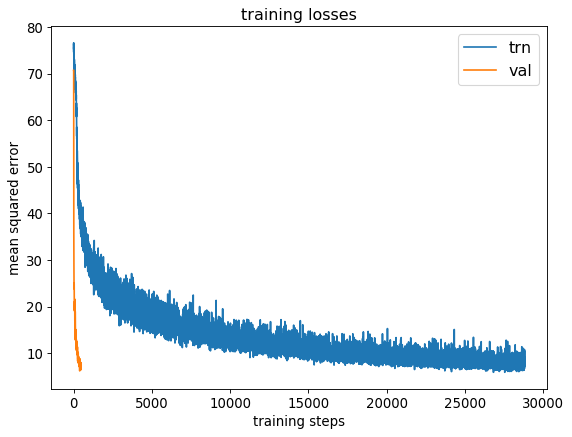

In [29]:
plt.plot(trn_losses)
plt.plot(val_losses)
plt.title("training losses")
plt.xlabel("training steps")
plt.ylabel("mean squared error")
plt.legend(["trn", "val"])
plt.show()

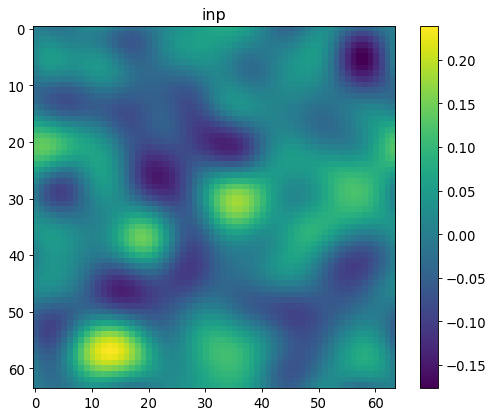

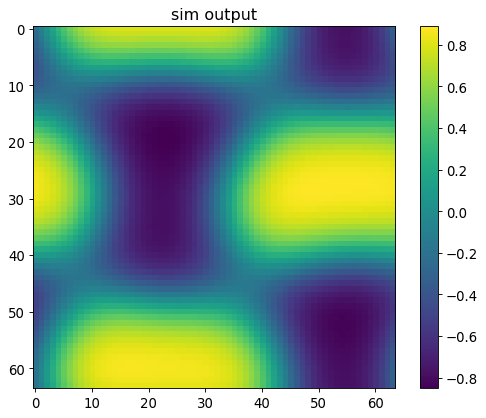

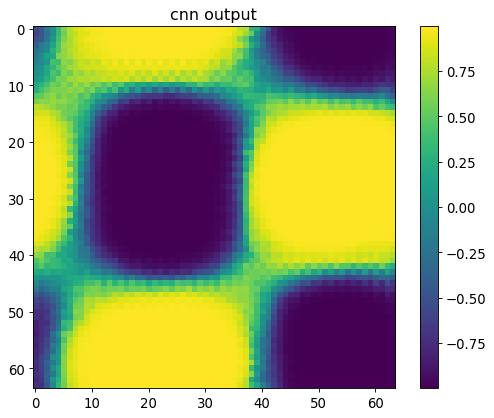

tensor(0.2077, device='cuda:0', dtype=torch.float64)


In [30]:
ix = 12

item_prd = val_dataset[ix]
x1 = item_prd['x'].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(y1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

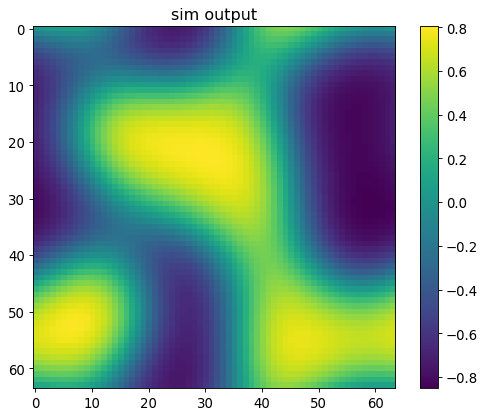

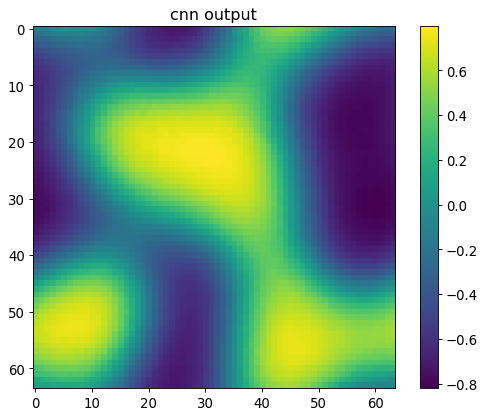

tensor(0.0025, device='cuda:0', dtype=torch.float64)


In [34]:
ix = 12

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

# draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

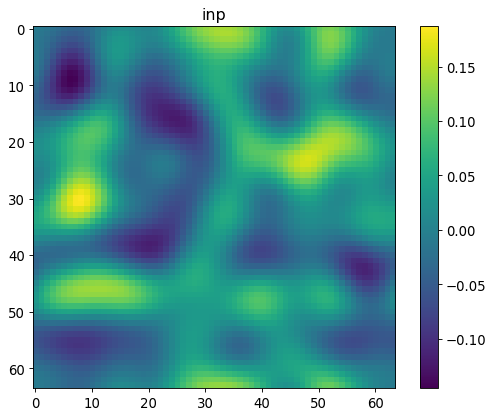

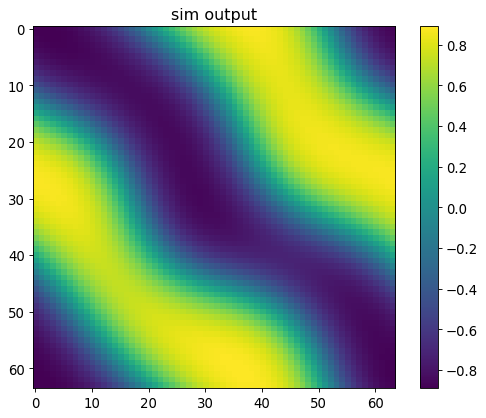

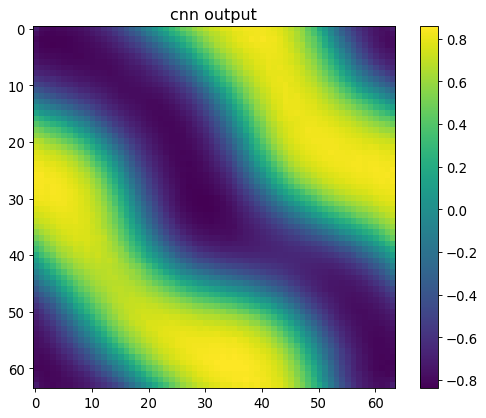

tensor(0.0019, device='cuda:0', dtype=torch.float64)


In [35]:
ix = 3

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

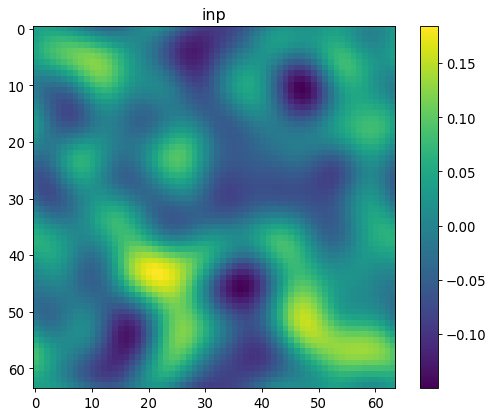

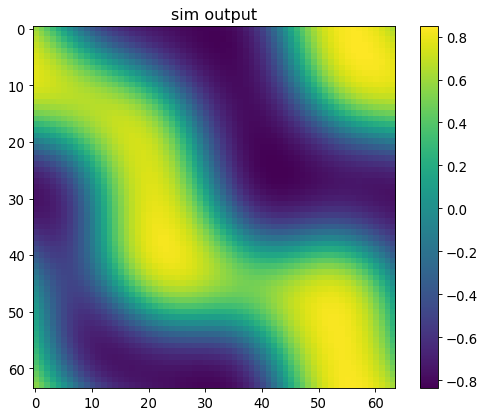

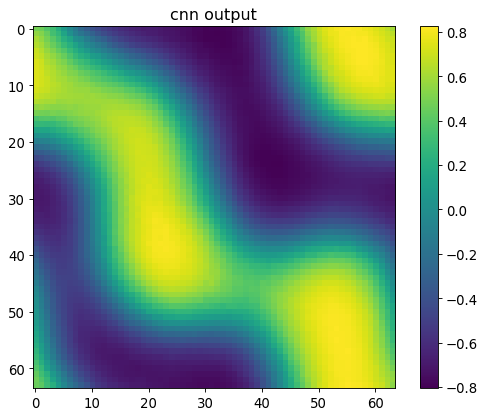

tensor(0.0017, device='cuda:0', dtype=torch.float64)


In [36]:
ix = 15

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)